In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import os
from io import open
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
import time
# from scipy.stats import gaussian_kde
# import scipy.stats as stats

### This is a sample for using hidden states transfer
### for LSTM and GRU based models

In [2]:
from dataset import CO2_synthetic_dataset
from time_series_models_hiddentransfer import GRUSeq2SeqWithAttention, LSTMSeq2Seq, SequenceDataset_multiYears
# from time_series_models import GRUSeq2SeqWithAttention, TimeSeriesModel, SequenceDataset
# from sequence_dataset import SequenceDataset, train_test_split

In [3]:
import kgml_lib

In [4]:
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [5]:
# define functions from kgml_lib
Z_norm = kgml_lib.Z_norm 
Z_norm_reverse = kgml_lib.Z_norm_reverse
get_gpu_memory = kgml_lib.get_gpu_memory

In [6]:
root_dir = 'E:/PyKGML/deposit_code_v2/'
data_path = root_dir +  'processed_data/'
output_path = root_dir + 'test_results/'

input_data = 'recotest_data_scaled_v4_100sample.sav'
sample_index_file = "traindataset_split_year_v1.sav"

pretrained_model = "recotest_v11_exp4.sav_step1"
output_model = "recotest_v11_exp4_sample.sav_step2"
synthetic_data = "sys_data2.sav"

dataset = CO2_synthetic_dataset(data_path, input_data, output_path, sample_index_file)
dataset.load_step2_data()

dataset.prepare_step2_data()

torch.Size([6570, 100, 19]) torch.Size([6570, 100, 3]) torch.Size([18, 100, 1])
['RADN', 'TMAX_AIR', 'TDIF_AIR', 'HMAX_AIR', 'HDIF_AIR', 'WIND', 'PRECN', 'Crop_Type', 'GPP', 'Year', 'TBKDS', 'TSAND', 'TSILT', 'TFC', 'TWP', 'TKSat', 'TSOC', 'TPH', 'TCEC']


In [7]:
X = dataset.X  #[365*18, 100, 19]
X = torch.transpose(X,1, 0) #[100, 365*18, 19]

Y1 = dataset.Y1 #[365*18, 100, 3]
Y1 = torch.transpose(Y1,1, 0) #[100, 365*18, 3]

Y2 = dataset.Y2 #[18, 100, 1]
Y2 = torch.transpose(Y2,1, 0)

y_scaler = dataset.Y1_scaler


In [8]:
num_input_features = 19
num_output_features = 3

input_dim = num_input_features
hidden_dim = 128
num_layers = 3
output_dim = num_output_features
dropout=0.2

In [10]:
# Choose one of the models below:
model = LSTMSeq2Seq(input_dim, hidden_dim, num_layers, output_dim)
# model = GRUSeq2Seq(input_dim, hidden_dim, num_layers, output_dim)

# model = EnhancedGRUModel(input_dim, hidden_dim, num_layers, output_dim)

# model = GRUSeq2SeqWithAttention(input_dim, hidden_dim, num_layers, output_dim, dropout)

# model = GRUSeq2SeqWithAttention(input_dim, hidden_dim, num_layers, output_dim)

In [11]:
total_years = 18
days_per_year = 365
# total_days = total_years * days_per_year
num_sites = X.shape[0] #100

batch_size=64

# model.train_test_split_bysite(X, Y1, num_sites, total_years, batch_size, days_per_year, split_method = 'temporal')

model.train_test_split_bysite(X, Y1, num_sites, total_years, batch_size, days_per_year, split_method = 'spatial')

# model.train_test_split(X, Y1, total_years, batch_size, split_method=1)

X_train shape is torch.Size([80, 6570, 19]), Y_train shape torch.Size([80, 6570, 3]), X_test torch.Size([20, 6570, 19]), Y_test torch.Size([20, 6570, 3])


In [12]:
learning_rate = 0.001
step_size = 20
max_epoch = 60
loss_function = nn.L1Loss()

# model.train_model(train_loader, test_loader, LR= learning_rate, step_size=20, gamma=0.8, maxepoch=60)
model.train_model(loss_fun=loss_function, LR= learning_rate, step_size= step_size, gamma=0.8, maxepoch=max_epoch)

Epoch 1/60 | LR: 0.001000, Train Loss: 0.7312, Test Loss: 0.7001
Train R2:  -0.03 Test R2:  -0.00
Epoch 2/60 | LR: 0.001000, Train Loss: 0.6964, Test Loss: 0.6635
Train R2:  -0.01 Test R2:  0.02
Epoch 3/60 | LR: 0.001000, Train Loss: 0.6609, Test Loss: 0.6174
Train R2:  0.01 Test R2:  0.06
Epoch 4/60 | LR: 0.001000, Train Loss: 0.6069, Test Loss: 0.5748
Train R2:  0.05 Test R2:  0.11
Epoch 5/60 | LR: 0.001000, Train Loss: 0.5754, Test Loss: 0.5350
Train R2:  0.11 Test R2:  0.19
Epoch 6/60 | LR: 0.001000, Train Loss: 0.5243, Test Loss: 0.4776
Train R2:  0.18 Test R2:  0.26
Epoch 7/60 | LR: 0.001000, Train Loss: 0.4743, Test Loss: 0.4737
Train R2:  0.25 Test R2:  0.29
Epoch 8/60 | LR: 0.001000, Train Loss: 0.4696, Test Loss: 0.4766
Train R2:  0.28 Test R2:  0.32
Epoch 9/60 | LR: 0.001000, Train Loss: 0.4654, Test Loss: 0.4540
Train R2:  0.32 Test R2:  0.40
Epoch 10/60 | LR: 0.001000, Train Loss: 0.4374, Test Loss: 0.4148
Train R2:  0.40 Test R2:  0.49
Epoch 11/60 | LR: 0.001000, Train Lo

In [13]:
model.test()

Test Loss: 0.1692
Test R2:  0.89


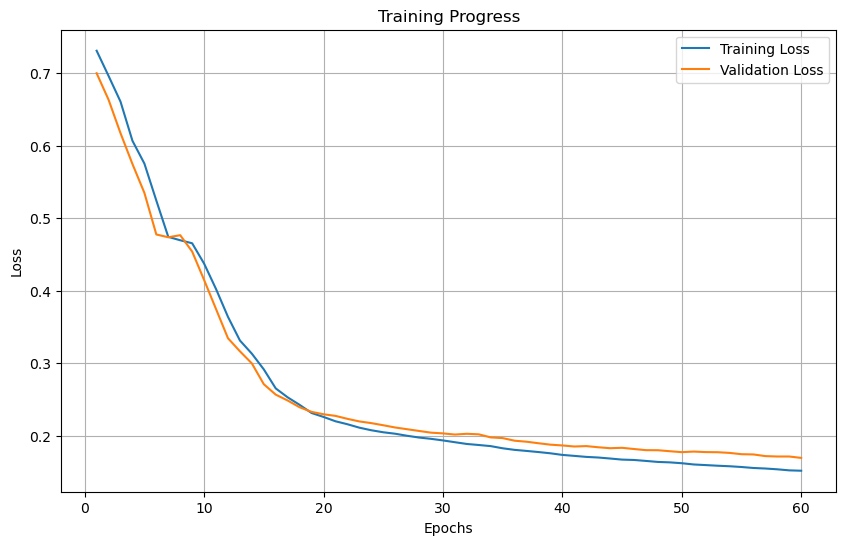

In [14]:
model.plot_training_curves()

In [15]:
output_feature_name = ['Ra','Rh','NEE']
model.get_R2_score(y_scaler, output_feature_name)

Feature Ra R2 Score is: 0.9562224204312342
Feature Rh R2 Score is: 0.8066152338784842
Feature NEE R2 Score is: 0.9255506434879718


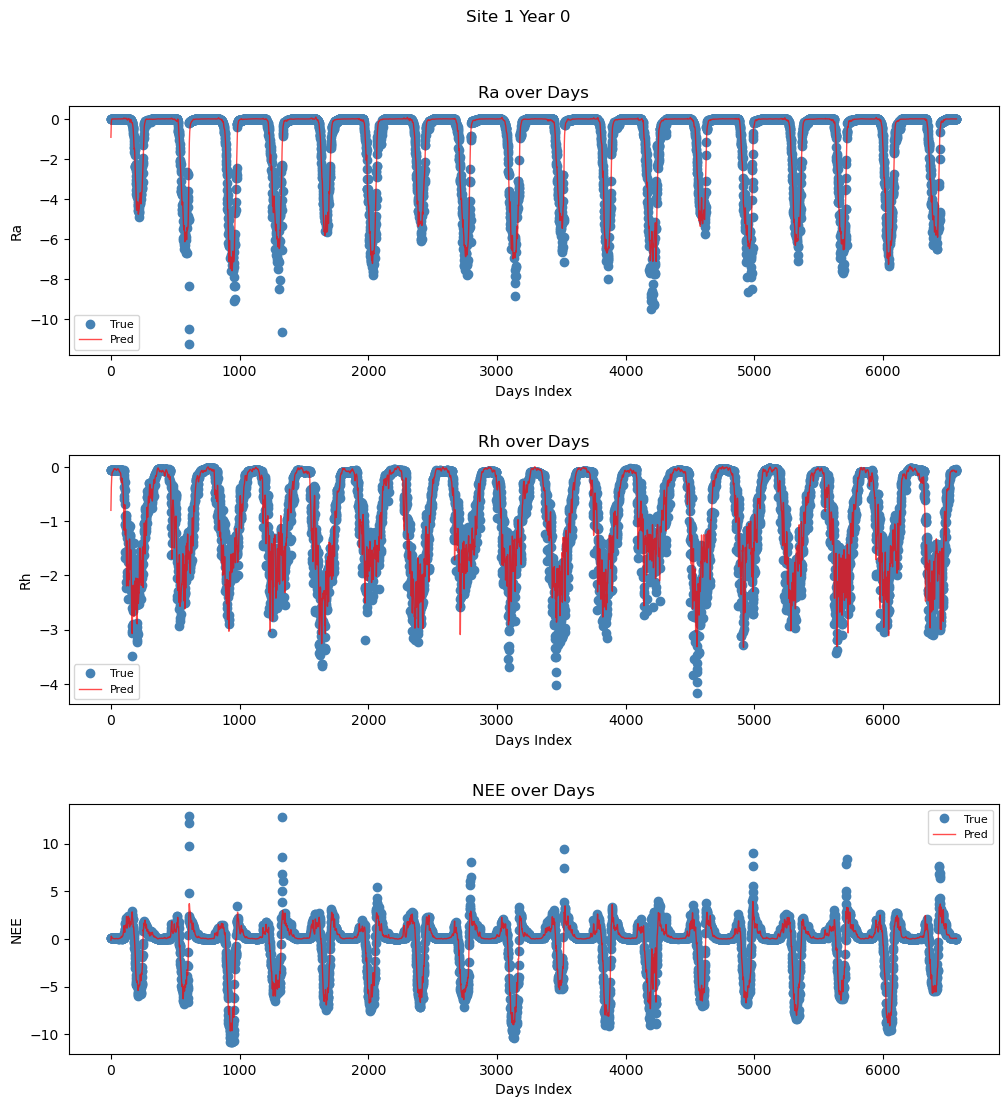

In [17]:
model.Vis_plot_prediction_result_time_series(y_scaler, output_feature_name, site=1, year=0)

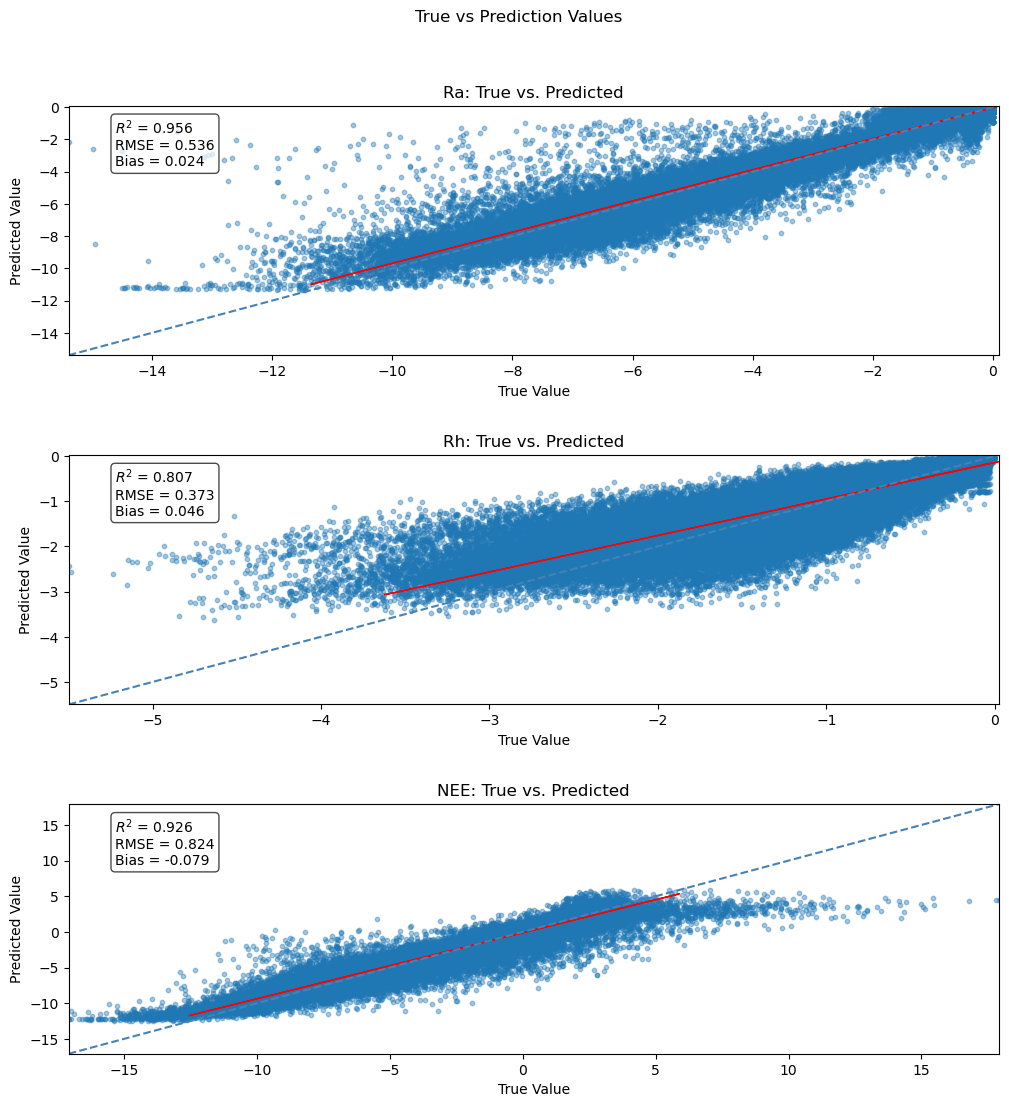

In [18]:
model.Vis_scatter_prediction_result(y_scaler, output_feature_name)